## 1. Importing data

### Mounting data

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
 ## The path to the dataset

train_dir = '/content/drive/MyDrive/Grad_pro Dataset/train'
test_dir = '/content/drive/MyDrive/Grad_pro Dataset/test'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
## Dataset flow for images
BATCH_SIZE = 32
IMG_SIZE = (100, 100)
num_classes = 4

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

class_names = train_dataset.class_names

Found 1715 files belonging to 4 classes.


In [ ]:
## Dataset flow for test images

test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 325 files belonging to 4 classes.


### Sample from the data

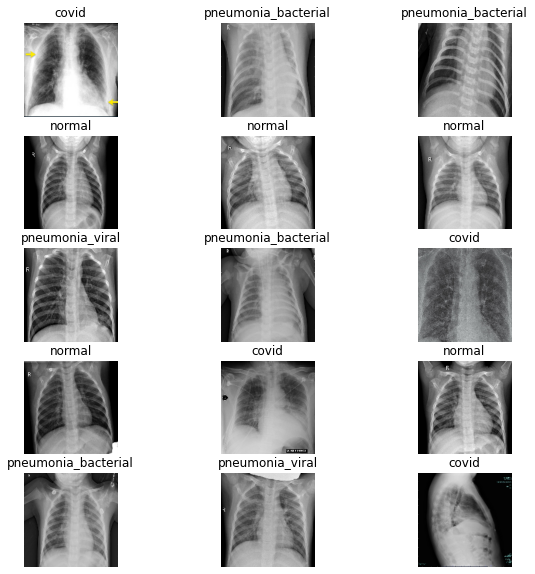

In [ ]:
## Dataset sample of images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmenatation 

In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)
test_batches = tf.data.experimental.cardinality(test_dataset)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 44
Number of validation batches: 10
Number of testing batches: 11


In [ ]:
## Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Data Augmentation Step
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Sample from augmented data

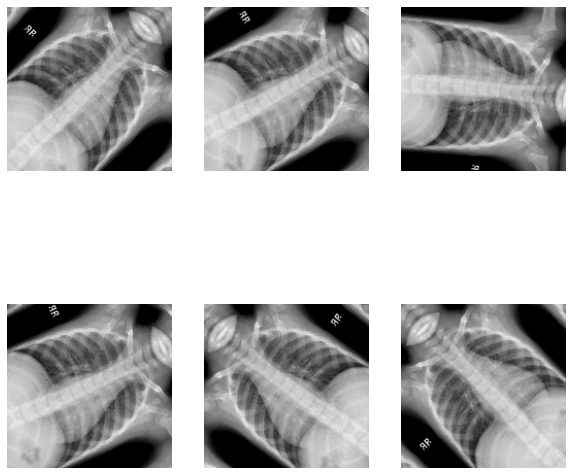

In [ ]:
## Dataset sample of images - Augmented data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 2. Data Preprocessing

In [ ]:
## Data preprocessing : Rescale pixel values
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model VGG-19

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 512)


In [ ]:
## Feature extraction
base_model.trainable = False

In [ ]:
# The base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) 

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes)  
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


## 3. Create the model

### Define the model

In [ ]:
## Define the model
inputs = tf.keras.Input(shape= IMG_SHAPE )
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),         metrics=['accuracy'])

### Model architecture

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

## 4. Training the model

In [ ]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 [==============================] - 7s 287ms/step - loss: 17.2795 - accuracy: 0.1090


In [ ]:
history = model.fit(train_dataset,                  epochs=initial_epochs,                    validation_data=validation_dataset)

Epoch 1/5
44/44 [==============================] - 418s 10s/step - loss: 10.3516 - accuracy: 0.1763 - val_loss: 12.6749 - val_accuracy: 0.1219
Epoch 2/5
44/44 [==============================] - 25s 434ms/step - loss: 9.2866 - accuracy: 0.2072 - val_loss: 11.2832 - val_accuracy: 0.1156
Epoch 3/5
44/44 [==============================] - 25s 439ms/step - loss: 7.8459 - accuracy: 0.2323 - val_loss: 9.1918 - val_accuracy: 0.1375
Epoch 4/5
44/44 [==============================] - 25s 434ms/step - loss: 6.9009 - accuracy: 0.2710 - val_loss: 7.8063 - val_accuracy: 0.1719
Epoch 5/5
44/44 [==============================] - 24s 418ms/step - loss: 6.0470 - accuracy: 0.2989 - val_loss: 6.3982 - val_accuracy: 0.2688


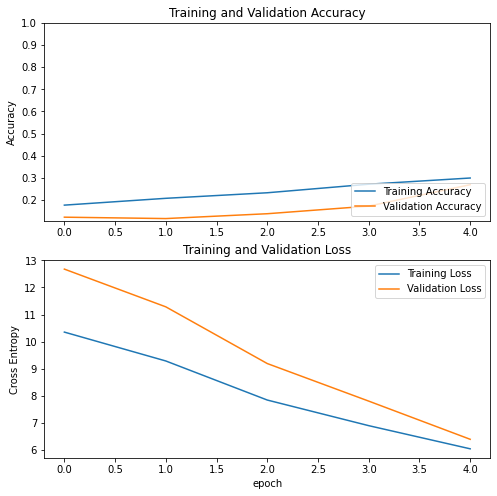

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [ ]:
## Fine tuning

base_model.trainable = True

## Setting only the last 54 layers as trainable
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), ## learning rate / 10
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [ ]:
## We have 56 trainable layers as we added extra layers

len(model.trainable_variables)

32

In [ ]:
## Fine tuning step
### total_epochs fine_tune = 30
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/55
44/44 [==============================] - 30s 483ms/step - loss: 2.2351 - accuracy: 0.4796 - val_loss: 0.7980 - val_accuracy: 0.7063
Epoch 6/55
44/44 [==============================] - 27s 480ms/step - loss: 0.8313 - accuracy: 0.6774 - val_loss: 0.5788 - val_accuracy: 0.8000
Epoch 7/55
44/44 [==============================] - 26s 461ms/step - loss: 0.6175 - accuracy: 0.7412 - val_loss: 0.5545 - val_accuracy: 0.8188
Epoch 8/55
44/44 [==============================] - 26s 460ms/step - loss: 0.6363 - accuracy: 0.7503 - val_loss: 0.3978 - val_accuracy: 0.8344
Epoch 9/55
44/44 [==============================] - 26s 462ms/step - loss: 0.5354 - accuracy: 0.7811 - val_loss: 0.5744 - val_accuracy: 0.8000
Epoch 10/55
44/44 [==============================] - 26s 467ms/step - loss: 0.5420 - accuracy: 0.7818 - val_loss: 0.4466 - val_accuracy: 0.8594
Epoch 11/55
44/44 [==============================] - 27s 482ms/step - loss: 0.5137 - accuracy: 0.8073 - val_loss: 0.4418 - val_accuracy: 0.81

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

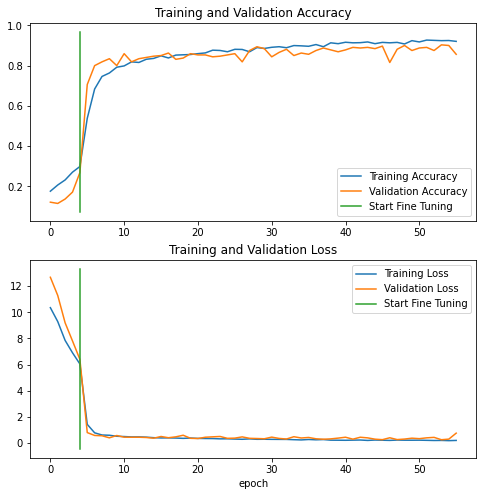

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 5. Get best weights

In [ ]:
## Best tuning step
model_path = '/content/drive/MyDrive/Grad_pro Dataset/model_weights.hdf5'

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

best_tune_epochs = 20

best_history = model.fit(train_dataset,
                         epochs=best_tune_epochs+55,
                         initial_epoch=55,
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_callback])

Epoch 56/75
44/44 [==============================] - 28s 488ms/step - loss: 0.2190 - accuracy: 0.9183 - val_loss: 0.2912 - val_accuracy: 0.8750

Epoch 00056: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/Grad_pro Dataset/model_weights.hdf5
Epoch 57/75
44/44 [==============================] - 27s 472ms/step - loss: 0.1620 - accuracy: 0.9362 - val_loss: 0.5893 - val_accuracy: 0.8750

Epoch 00057: val_accuracy did not improve from 0.87500
Epoch 58/75
44/44 [==============================] - 26s 467ms/step - loss: 0.1874 - accuracy: 0.9319 - val_loss: 0.2776 - val_accuracy: 0.9250

Epoch 00058: val_accuracy improved from 0.87500 to 0.92500, saving model to /content/drive/MyDrive/Grad_pro Dataset/model_weights.hdf5
Epoch 59/75
44/44 [==============================] - 26s 460ms/step - loss: 0.1730 - accuracy: 0.9326 - val_loss: 0.2886 - val_accuracy: 0.9031

Epoch 00059: val_accuracy did not improve from 0.92500
Epoch 60/75
44/44 [========================

In [ ]:
model.load_weights('/content/drive/MyDrive/Grad_pro Dataset/model_weights.hdf5')

In [ ]:
_, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

11/11 [==============================] - 121s 2s/step - loss: 0.5433 - accuracy: 0.8769
Test accuracy: 87.69%


### Creating sub_model for hybridization

In [ ]:
sub_model = tf.keras.Model(inputs,outputs)
sub_model.load_weights('/content/model_weights.hdf5')

In [ ]:
model.summary()
sub_model = tf.keras.Model(model.input, model.layers[-2].output)
print('\n\n\n\n######### The other model #########\n\n\n\n')
sub_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### ML Modeling 
Using the machine learning model in order to have a classifier for the features

In [ ]:
sub_model.predict(train_dataset)

array([[2.25610882e-02, 1.31199300e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.32080257e+00, 4.40815240e-02],
       [5.58758527e-02, 3.00537646e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.87149727e-01],
       [1.66589662e-01, 3.49420011e-01, 0.00000000e+00, ...,
        0.00000000e+00, 7.84115773e-03, 3.21595668e-04],
       ...,
       [1.14502795e-01, 1.43905950e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.11374911e-02, 7.23320007e-01],
       [0.00000000e+00, 1.48141170e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.72241950e-04, 7.78619060e-03],
       [2.10431498e-03, 1.66715360e+00, 7.98387975e-02, ...,
        0.00000000e+00, 8.55198205e-01, 1.81284204e-01]], dtype=float32)